In [5]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#download provided NFL data
#assumes that all files are in the same folder as this file
df_games = pd.read_csv('games.csv')
df_player_play = pd.read_csv('player_play.csv')
df_players = pd.read_csv('players.csv')
df_plays = pd.read_csv('plays.csv')
df_w1 = pd.read_csv('tracking_week_1.csv')
df_w2 = pd.read_csv('tracking_week_2.csv')
df_w3 = pd.read_csv('tracking_week_3.csv')
df_w4 = pd.read_csv('tracking_week_4.csv')
df_w5 = pd.read_csv('tracking_week_5.csv')
df_w6 = pd.read_csv('tracking_week_6.csv')
df_w7 = pd.read_csv('tracking_week_7.csv')
df_w8 = pd.read_csv('tracking_week_8.csv')
df_w9 = pd.read_csv('tracking_week_9.csv')

In [7]:
#concatenate the player tracking dataframes
tracking = pd.concat([df_w1,df_w2,df_w3,df_w4,df_w5,df_w6,df_w7,df_w8,df_w9])

In [8]:
#Function that changes all plays to going in the same direction, and also converts floats to ints to save memory
def standardize_df(df):
    
    #flip the x and y coordinates for plays, so they all go left to right
    df['x_std'] = np.where(
        df["playDirection"] == "left",
        (120 - df["x"].to_numpy()) * 100,
        df["x"].to_numpy() * 100
    ).astype(int)
    df['y_std'] = np.where(
        df["playDirection"] == "left",
        (120 - df["y"].to_numpy()) * 100,
        df["y"].to_numpy() * 100
    ).astype(int)

    #standardize and clean the 'o' column to always go left to right
    df["o_std"] = (-(df["o"] - 90)) % 360
    df["o_std"] = np.where(
        df["playDirection"] == "left",
        (180 - df["o_std"]) % 360,
        df["o_std"]
    )
    df["o_std"] = (df["o_std"] * 100).fillna(0).astype(int) #convert to int
    
    #standardize and clean the 'dir' column to always go left to right
    df["dir_std"] = (-(df["dir"] - 90)) % 360
    df["dir_std"] = np.where(
        df["playDirection"] == "left",
        (180 - df["dir_std"]) % 360, 
        df["dir_std"]
    )
    df["dir_std"] = (df["dir_std"] * 100).fillna(0).astype(int)  #convert to int

    #convert other cells to int
    df['s_std'] = (df['s']*100).astype(int)
    df['a_std'] = (df['a']*100).astype(int)
    df['dis_std'] = (df['dis']*100).astype(int)

    #downcast integer columns to save memory
    df['x_std'] = pd.to_numeric(df['x_std'], downcast='integer')
    df['y_std'] = pd.to_numeric(df['y_std'], downcast='integer')
    df['o_std'] = pd.to_numeric(df['o_std'], downcast='integer')
    df['dis_std'] = pd.to_numeric(df['dis_std'], downcast='integer')
    df['dir_std'] = pd.to_numeric(df['dir_std'], downcast='integer')
    df['s_std'] = pd.to_numeric(df['s_std'], downcast='integer')
    df['a_std'] = pd.to_numeric(df['a_std'], downcast='integer')


In [9]:
#apply to tracking
standardize_df(tracking)

In [10]:
#check what players were in motion (can also check shiftSinceLineset later)
df_player_play_motion_ids = df_player_play[df_player_play['motionSinceLineset'] == True][['gameId','playId','nflId']]

In [11]:
#create a dataframe with only the players who were labeled as having MotionSinceLineset
tracking_motion = tracking.merge(df_player_play_motion_ids, on = ['gameId','playId','nflId'], how = 'inner')
tracking_motion = tracking_motion.drop(columns=['x', 'y', 's', 'a','dis', 'o', 'dir'])

In [12]:
#calculate the distance from player to football

tracking_football = tracking[tracking['displayName'] == 'football'][['gameId','playId','frameId','x_std','y_std']]

tracking_motion = tracking_motion.merge(tracking_football, on = ['gameId','playId','frameId'], suffixes=('','_fb'))

tracking_motion['dis_fb_x'] = tracking_motion['x_std'] - tracking_motion['x_std_fb']
tracking_motion['dis_fb_y'] = tracking_motion['y_std'] - tracking_motion['y_std_fb']

In [13]:
#creates a column of the first frame where the passed event occurred on the specific play
def find_frame_of_event(df, event_name, event_suffix):
    
    #get frameId for every event occurrence per play
    frameIds = df[df['event'] == event_name][['gameId','playId','frameId']].drop_duplicates()

    #get frameId column by merging dataframes
    merged_df = df.merge(frameIds, on=['gameId', 'playId'], suffixes=('', event_suffix))

    return merged_df

#filters the tracking data passed to the frames between 'line_set' and 'ball_snap'
def filter_to_between_line_set_ball_snap(df):

    #filter out any plays where lineset was not marked (ended up removing 0.7% of frames: (1 - len(filtered_tracking_motion) / len(tracking_motion)))
    df_new = (
        df
        .groupby(['gameId', 'playId'])
        .filter(lambda x: (x['event'] == 'line_set').any())
        .reset_index(drop=True)
    )

    #remove frames after ball_snap
    df_new = df_new[df_new['frameType'] != 'AFTER_SNAP']
    
    #add column for frameId when lineset occurred
    filtered_df = find_frame_of_event(df_new, 'line_set', '_ls')
    
    #remove frames before line_snap
    filtered_df = filtered_df[filtered_df['frameId'] >= filtered_df['frameId_ls']]

    #add column for frameId when the ball was snapped
    filtered_df = find_frame_of_event(filtered_df, 'ball_snap', '_bs')

    return filtered_df

In [14]:
tracking_motion_filtered = filter_to_between_line_set_ball_snap(tracking_motion)

In [15]:
tracking_motion_filtered.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,dir_std,s_std,a_std,dis_std,x_std_fb,y_std_fb,dis_fb_x,dis_fb_y,frameId_ls,frameId_bs
0,2022091200,64,46189.0,Will Dissly,43,BEFORE_SNAP,2022-09-13 00:16:07.7,89.0,SEA,right,...,34068,6,17,1,3949,2394,-477,252,43,114
1,2022091200,64,46189.0,Will Dissly,44,BEFORE_SNAP,2022-09-13 00:16:07.8,89.0,SEA,right,...,33651,5,11,0,3949,2394,-477,252,43,114
2,2022091200,64,46189.0,Will Dissly,45,BEFORE_SNAP,2022-09-13 00:16:07.9,89.0,SEA,right,...,35166,8,17,1,3949,2394,-477,252,43,114
3,2022091200,64,46189.0,Will Dissly,46,BEFORE_SNAP,2022-09-13 00:16:08,89.0,SEA,right,...,34832,9,12,1,3949,2395,-475,251,43,114
4,2022091200,64,46189.0,Will Dissly,47,BEFORE_SNAP,2022-09-13 00:16:08.1,89.0,SEA,right,...,34926,11,12,1,3949,2395,-474,250,43,114


In [16]:
#drop unnecessary columns
tracking_simple = tracking_motion_filtered.drop(columns=['frameType','time', 'jerseyNumber','playDirection','event'])

In [17]:
#calculate frames before snap (note: a frame is .1 second)
tracking_simple['frames_bf_snap'] = tracking_simple['frameId_bs'] - tracking_simple['frameId']

#player's distance from football (x and y)
tracking_simple['x_dis_from_fb'] = tracking_simple['x_std'] - tracking_simple['x_std_fb']
tracking_simple['y_dis_from_fb'] = tracking_simple['y_std'] - tracking_simple['y_std_fb']

In [18]:
#make columsn of the player's coordinates at the linesnap
tracking_simple.loc[tracking_simple['frameId'] == tracking_simple['frameId_ls'], 'initial_x_std'] = tracking_simple['x_std']
tracking_simple['initial_x_std'] = tracking_simple['initial_x_std'].ffill().astype(int)

tracking_simple.loc[tracking_simple['frameId'] == tracking_simple['frameId_ls'], 'initial_y_std'] = tracking_simple['y_std']
tracking_simple['initial_y_std'] = tracking_simple['initial_y_std'].ffill().astype(int)

#find how far the player has moved from their initial coordinates at every frame
tracking_simple['x_change_all'] = tracking_simple['initial_x_std'] - tracking_simple['x_std']
tracking_simple['y_change_all'] = tracking_simple['initial_y_std'] - tracking_simple['y_std']

In [19]:
#find change in x,y coordinates per frame
tracking_simple['x_change'] = tracking_simple.groupby(['gameId','playId','nflId'])['x_std'].diff().fillna(0).astype(int)
tracking_simple['y_change'] = tracking_simple.groupby(['gameId','playId','nflId'])['y_std'].diff().fillna(0).astype(int)

<Axes: xlabel='y_change', ylabel='Count'>

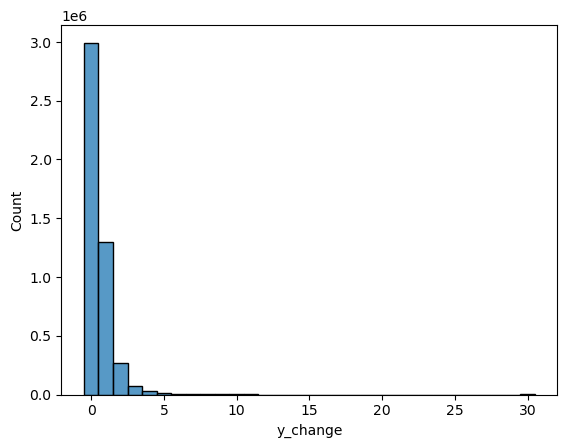

In [20]:
#Need to create an estimate of when a person is in motion, see what the change in y is
#initial guess, when over 5 (confirm by looking at data)

#see what average movement for non-motion players is

tracking_avg_movement = tracking.drop(columns=['x', 'y', 's', 'a','dis', 'o', 'dir'])

df_player_play_motion_ids_false = df_player_play[df_player_play['motionSinceLineset'] == False][['gameId','playId','nflId']]
tracking_avg_movement = tracking_avg_movement.merge(df_player_play_motion_ids_false, on = ['gameId','playId','nflId'], how = 'inner')

tracking_avg_movement = filter_to_between_line_set_ball_snap(tracking_avg_movement)
tracking_avg_movement = tracking_avg_movement.drop(columns=['frameType','time', 'jerseyNumber','playDirection','event'])

tracking_avg_movement['x_change'] = tracking_avg_movement.groupby(['gameId','playId','nflId'])['x_std'].diff().fillna(0).astype(int)
tracking_avg_movement['y_change'] = tracking_avg_movement.groupby(['gameId','playId','nflId'])['y_std'].diff().fillna(0).astype(int)

tracking_avg_movement['y_change'] = abs(tracking_avg_movement['y_change'])

#histplot for players who were not in motion
sns.histplot(tracking_avg_movement['y_change'].apply(lambda x: min(x, 30)), discrete=True)

In [21]:
tracking_avg_movement['y_change'].describe()

count    4.702742e+06
mean     5.484030e-01
std      1.523355e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.460000e+02
Name: y_change, dtype: float64

In [22]:
tracking_avg_movement['y_change'].quantile(.99)

4.0

<Axes: xlabel='y_change', ylabel='Count'>

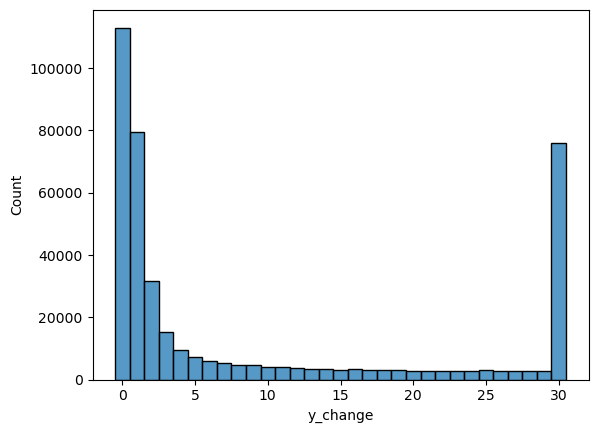

In [23]:
#compare to histograph from players in motion
sns.histplot(tracking_simple['y_change'].apply(lambda x: min(abs(x), 30)), discrete=True)

In [24]:
#based on above results, mark a player as in motion when their y_change is above 5
tracking_simple['in_motion'] = (tracking_simple['y_change'] >= 5)*1

In [25]:
tracking_simple.head()

,gameId,playId,nflId,displayName,frameId,club,x_std,y_std,o_std,dir_std,...,frames_bf_snap,x_dis_from_fb,y_dis_from_fb,initial_x_std,initial_y_std,x_change_all,y_change_all,x_change,y_change,in_motion
0,2022091200,64,46189.0,Will Dissly,43,SEA,3472,2646,443,34068,...,71,-477,252,3472,2646,0,0,0,0,0
1,2022091200,64,46189.0,Will Dissly,44,SEA,3472,2646,565,33651,...,70,-477,252,3472,2646,0,0,0,0,0
2,2022091200,64,46189.0,Will Dissly,45,SEA,3472,2646,709,35166,...,69,-477,252,3472,2646,0,0,0,0,0
3,2022091200,64,46189.0,Will Dissly,46,SEA,3474,2646,831,34832,...,68,-475,251,3472,2646,-2,0,2,0,0
4,2022091200,64,46189.0,Will Dissly,47,SEA,3475,2645,1172,34926,...,67,-474,250,3472,2646,-3,1,1,-1,0


In [57]:
#get tracking data for only linemen (needed in feature creation)
tracking_snap = tracking[tracking['event'] == 'ball_snap']
df_players_line = df_players[df_players['position'].isin(['T', 'G', 'C'])][['nflId']]
tracking_linemen = tracking_snap.merge(df_players_line, on = ['nflId'])[['gameId','playId','frameId','y_std']]

In [59]:
#export to csv, use in feature creation file
tracking_simple.to_csv('tracking_simple.csv',index=False)
tracking_football.to_csv('tracking_football.csv',index=False)
tracking_linemen.to_csv('tracking_linemen.csv',index=False)